# This notebook is read only! Do not run!

## Prepare

In [49]:
import numpy as np
import torch
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rc('font', family='NanumGothicCoding')

def softmax(x):
    # x has shape [batch_size, n_classes]
    x = x - np.tile(np.max(x, axis=1).reshape((-1,1)), x.shape[1])
    
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n


# "integer -> word" decoder 
decoder = np.load('2017_decoder.npy', allow_pickle=True)[()]

# for restoring document ids, "id used while training -> initial id"
doc_decoder = np.load('doc_decoder.npy', allow_pickle=True)[()]


## Show Topics

In [3]:
state = torch.load('./data2-train-bak/6_epoch_model_state.pytorch', map_location=lambda storage, loc: storage)

n_topics = state['topics.topic_vectors'].shape[0]

doc_weights = state['doc_weights.weight'].cpu().clone().numpy()
topic_vectors = state['topics.topic_vectors'].cpu().clone().numpy()
word_vectors = state['neg.embedding.weight'].cpu().clone().numpy()

# distribution over the topics for each document
topic_dist = softmax(doc_weights)

similarity = np.matmul(topic_vectors, word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

for j in range(n_topics):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)
    

topic 1 : 사진 영상 화제 공감 기다립니다 소중 판단 언론 n 독자
topic 2 : 미사일 북한 발사 핵 탄도 도발 북 군사 회담 ICBM
topic 3 : 생산 자동차 부품 공장 전기차 수주 수출 전기 업체 현대차
topic 4 : 미국 현지 뉴욕 영국 AP 특파원 트럼프 워싱턴 러시아 도널드
topic 5 : 수상 대회 참가 개최 시상식 예선 선수 우수 출전 우승
topic 6 : 부담 대출 소득 경우 비율 기준 가계 규제 부채 제도
topic 7 : 데일리 경제 종합 페이스북 맺 정보 edaily 핫 플 스타
topic 8 : 사람 때 되 생각 없 일 좋 마음 하 알
topic 9 : 낙 뉴스 오늘 asiae 경제 서울 아시아 티 규의 이야기
topic 10 : 뉴스 서울 MSI 네이버 오전 빅 데이터 가 사진 페이스북
topic 11 : 디자인 브랜드 모델 트 뉴 출시 에디션 카 콘셉트 BMW
topic 12 : 대통령 정부 문재인 문 청와대 트럼프 안보 외교 논의 입장
topic 13 : 상품 출시 브랜드 증정 매장 스토어 쇼핑 고객 백화점 멤버십
topic 14 : 농가 계란 식품 가금 방역 산란계 농장 구제역 살충제 조류
topic 15 : 질환 환자 치료 혈관 병원 뇌졸중 암 수술 호흡기 건강
topic 16 : 맛 과일 돼지고기 음료 메뉴 풍미 재료 먹 크림 상큼
topic 17 : 사고 화재 소방 작업 인명 대피 발생 부상자 지진 소방본부
topic 18 : 경남 부산 창원 해양 전남 울산 하경민 통영 군청 여수
topic 19 : 구속 선고 기소 재판 혐의 항소심 징역 법원 영장 뇌물
topic 20 : 대선 후보 안철수 당 정당 민주당 바른 안희정 지지율 유승민
topic 21 : 축제 체험 해변 투어 리조트 전시 열린다 공원 감상 공연
topic 22 : 나눔 봉사 복지 기탁 기부 어르신 봉사자 성금 후원 캠페인
topic 23 : fn 연예뉴스 뉴스 스타 때리 골 파스 보이 사진 서울
topic 24 : 구속 수사 검찰 특검 

## Topic distribution

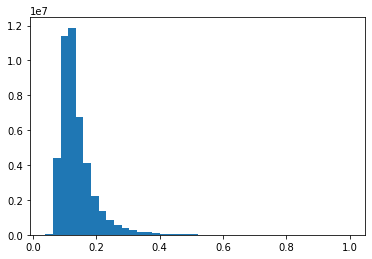

In [4]:
# distribution of nonzero probabilities
dist = topic_dist.reshape(-1)
plt.hist(dist[dist > 0.01], bins=40);


## Correlation of topic assignments

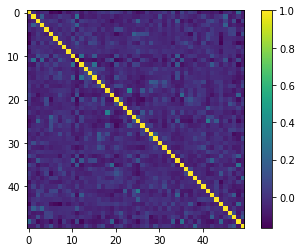

In [5]:
corr = np.corrcoef(topic_dist.transpose(1, 0))
plt.imshow(corr);
plt.colorbar();


## Plots of topics over time

In [8]:
dates = np.load('dates.npy', allow_pickle=True)
prominent_topic = np.argmax(topic_dist, axis=1)

df = pd.DataFrame()
df['ptopic'] = prominent_topic
np_dates = np.array([pd.to_datetime(date) for date in dates])
df['date'] = np_dates
df['count'] = [1 for i in range(len(df))]

df_groupby = df.groupby(['ptopic', 'date']).agg('sum')

/home/sebkim/new-anaconda3/envs/mytorch/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


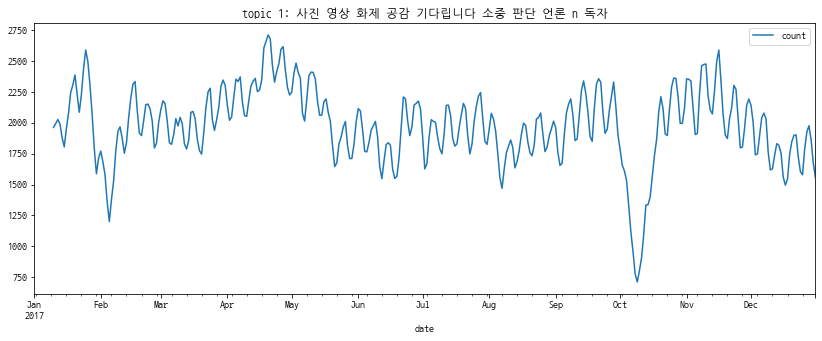

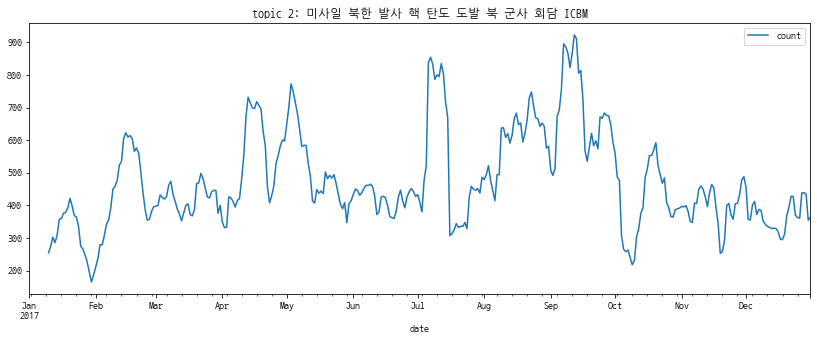

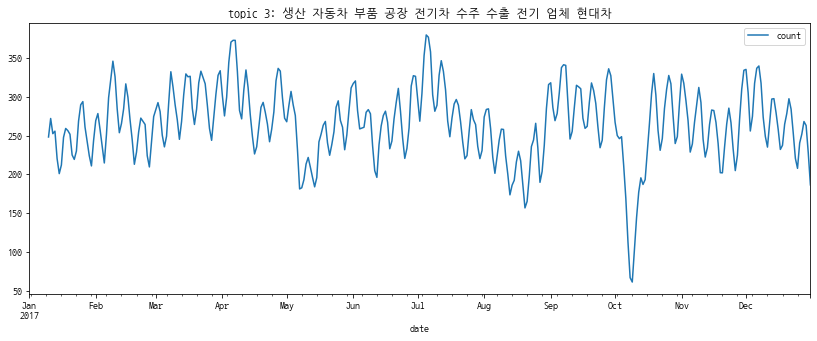

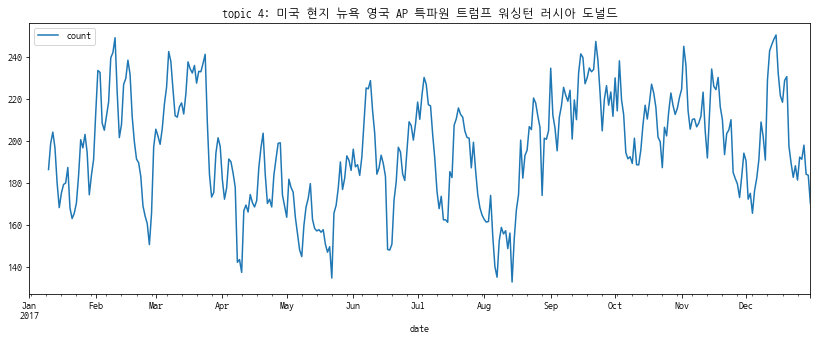

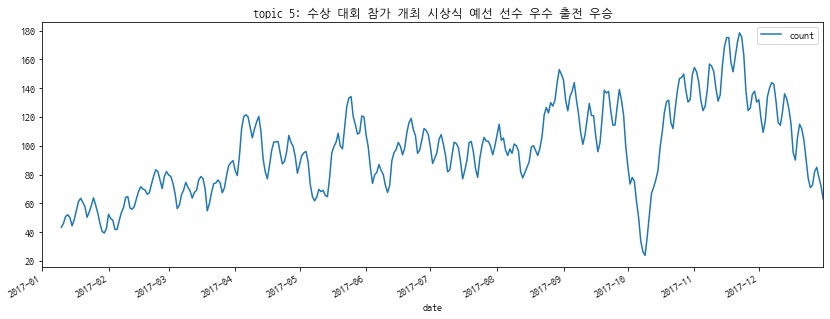

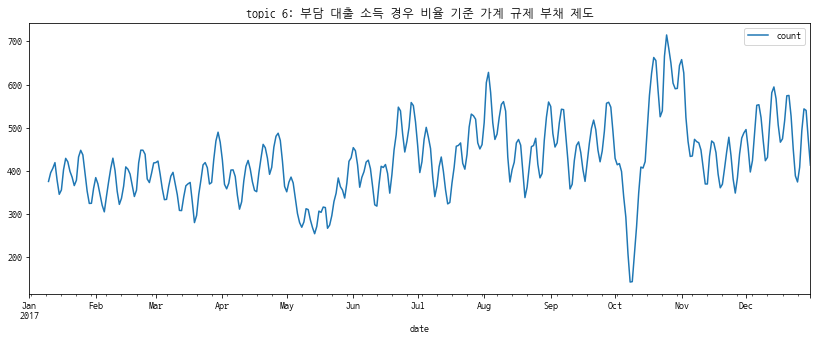

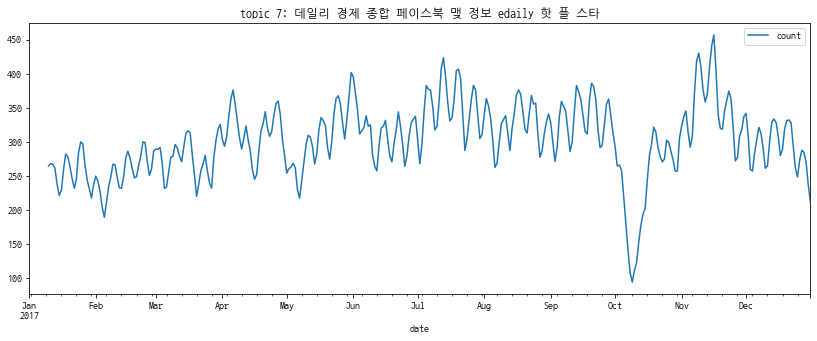

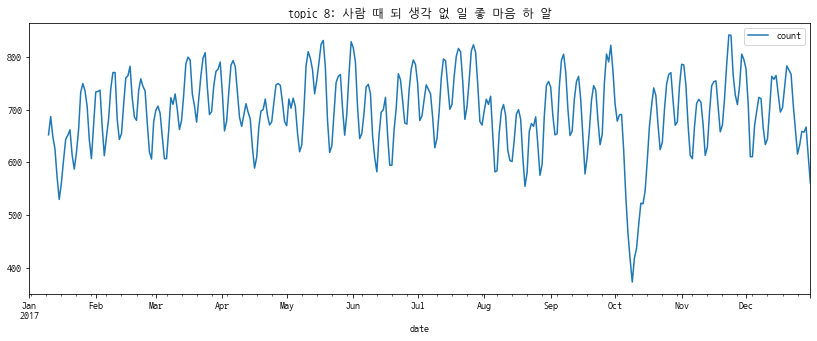

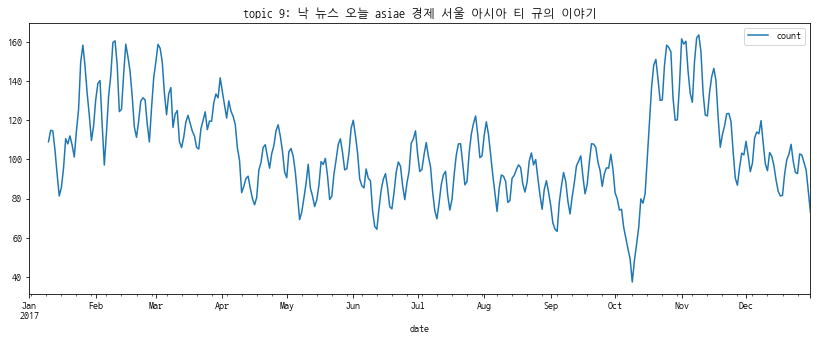

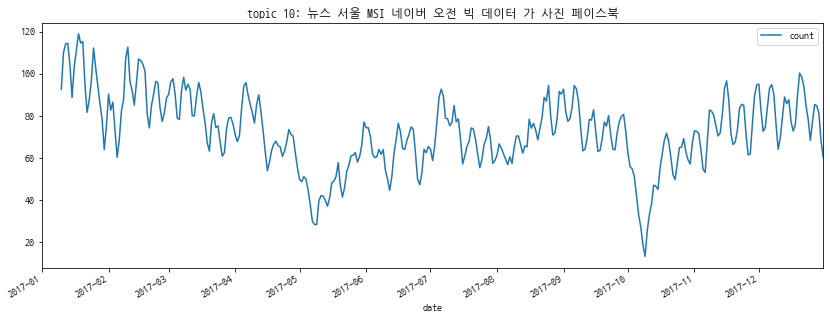

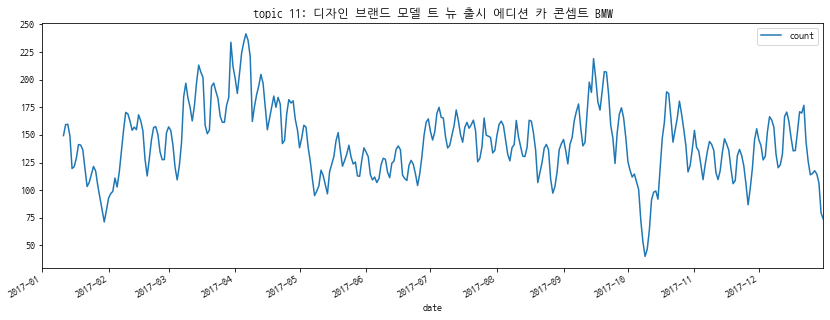

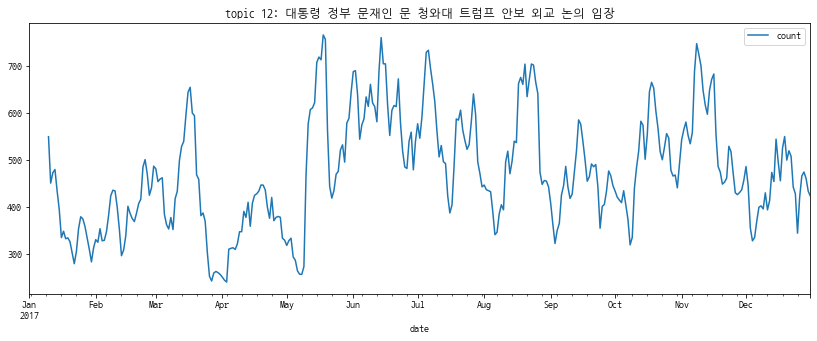

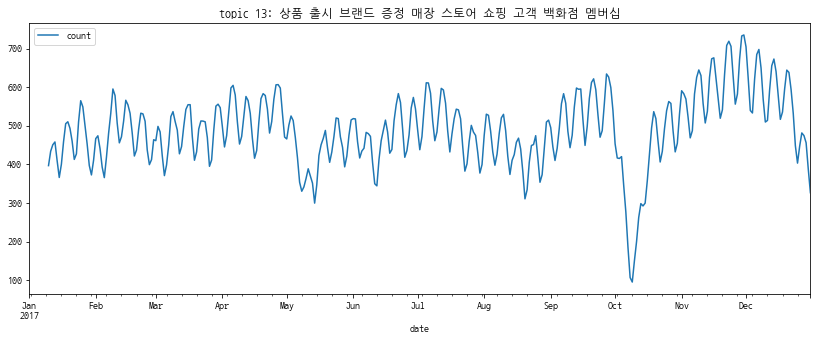

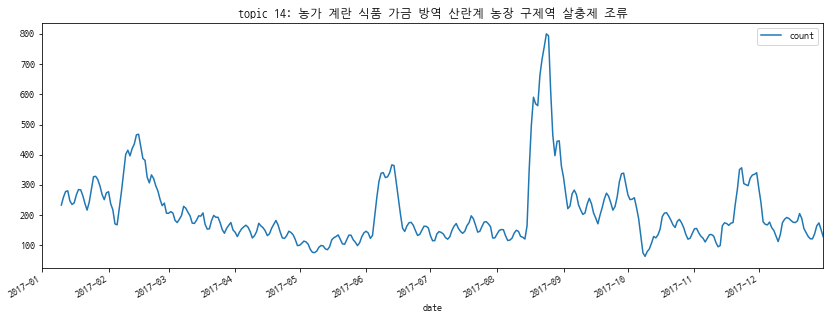

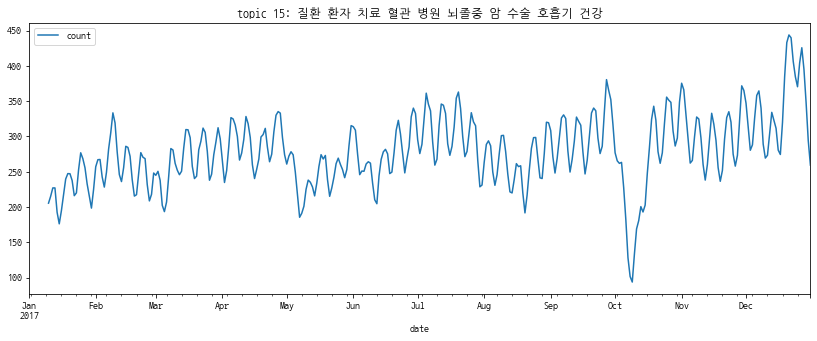

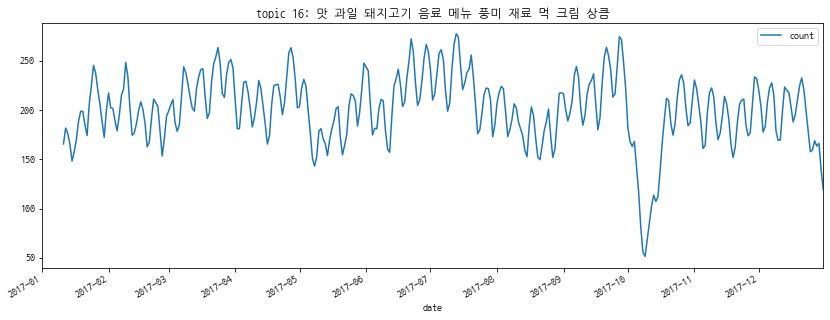

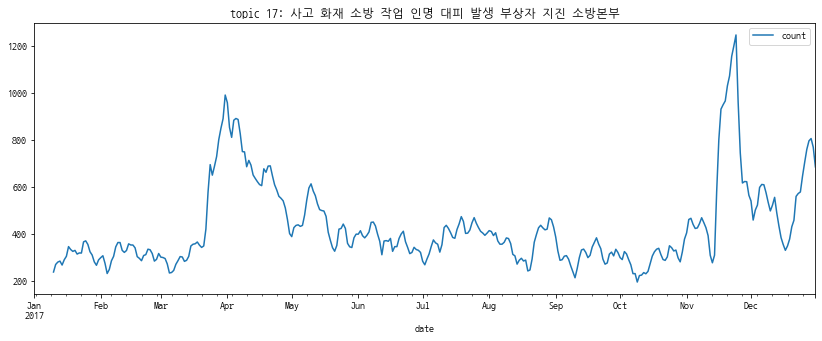

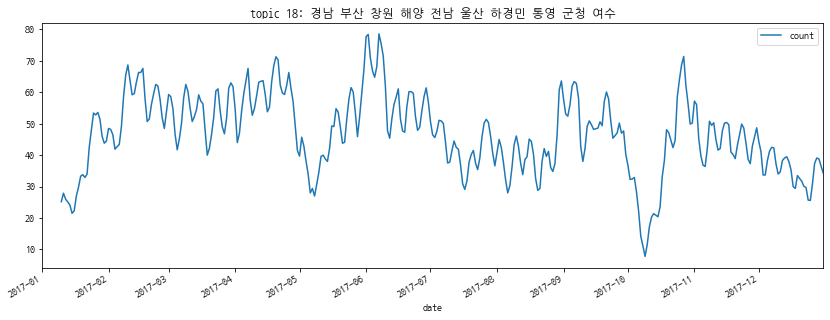

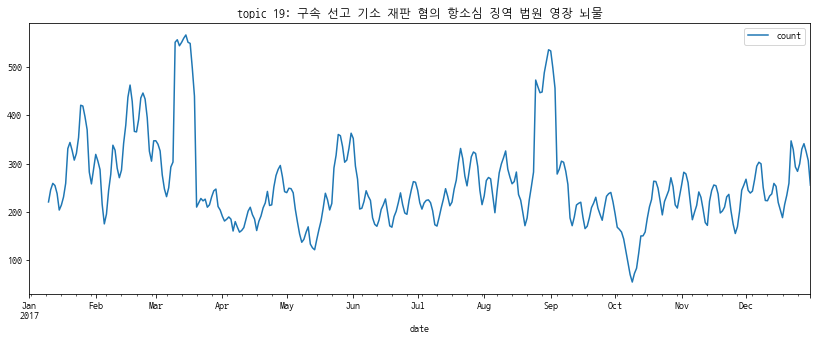

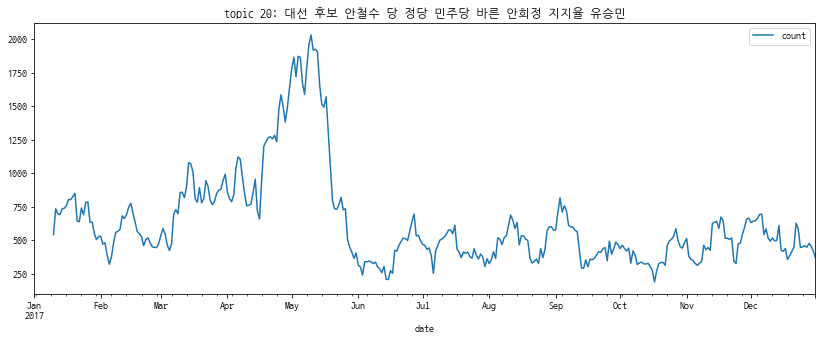

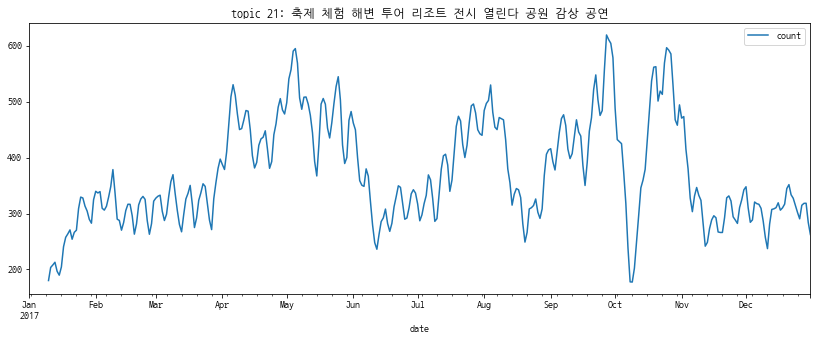

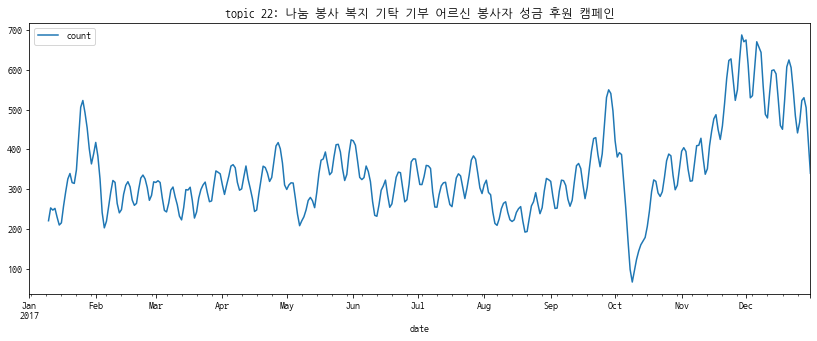

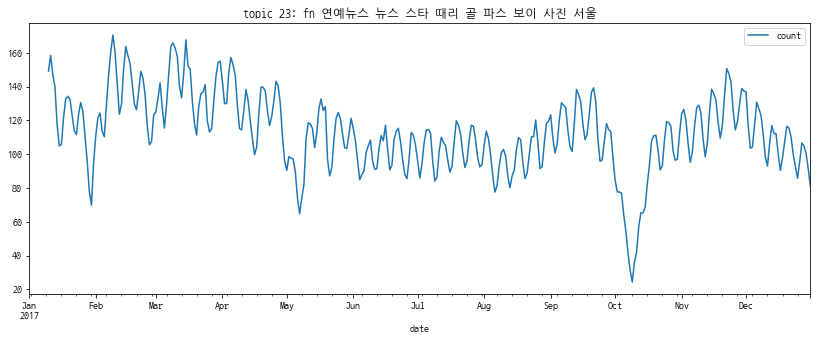

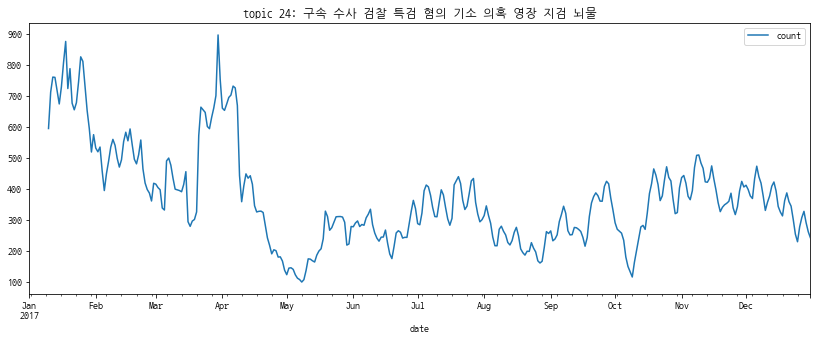

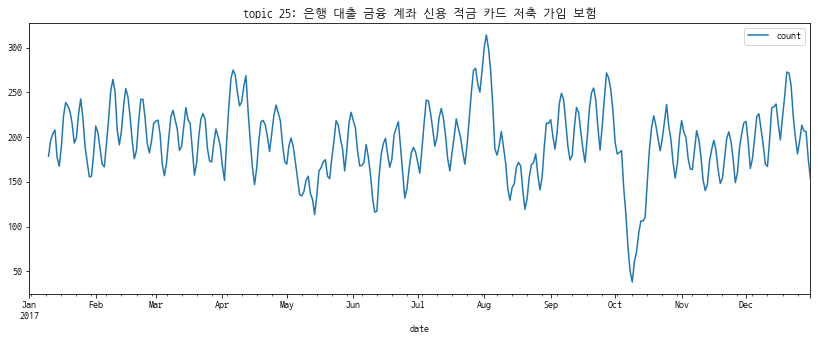

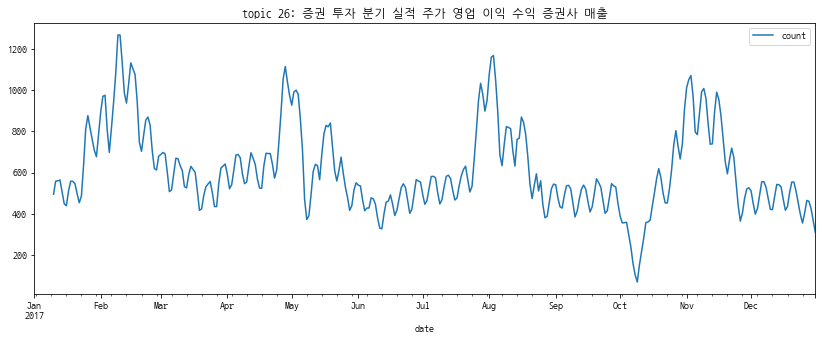

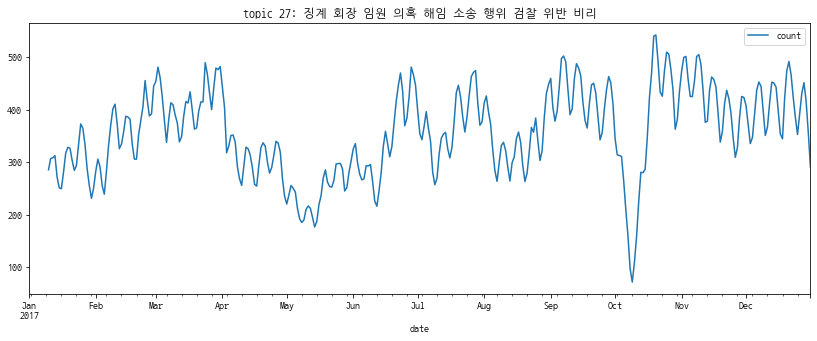

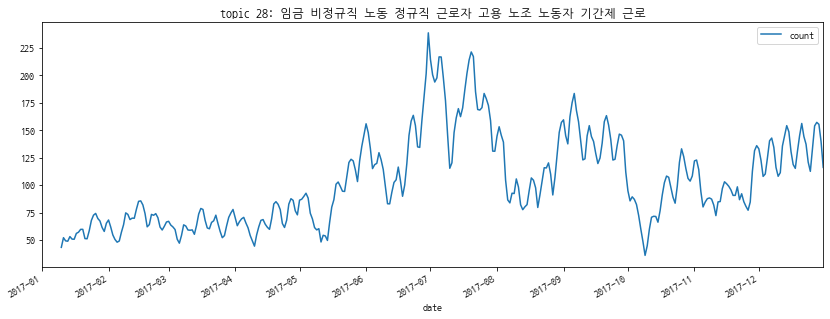

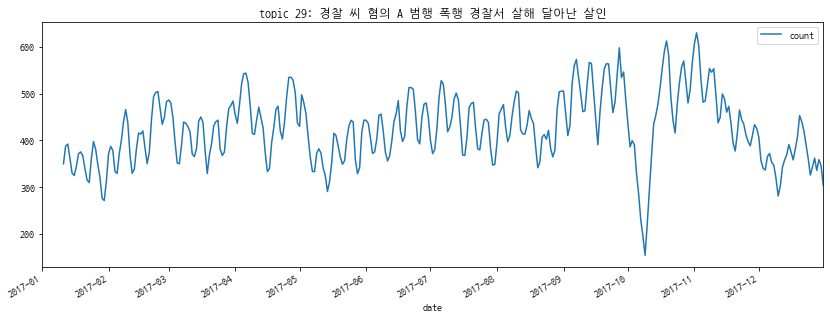

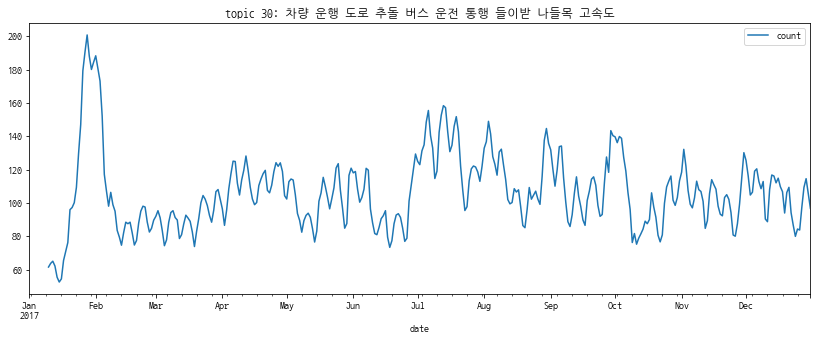

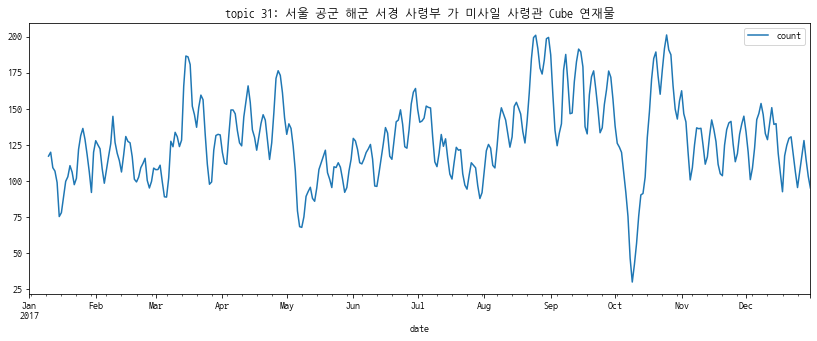

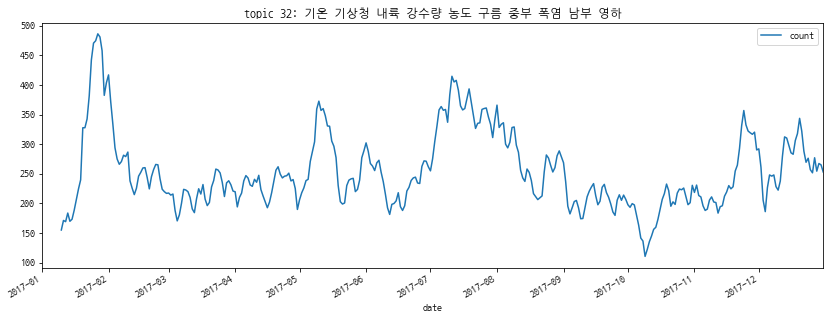

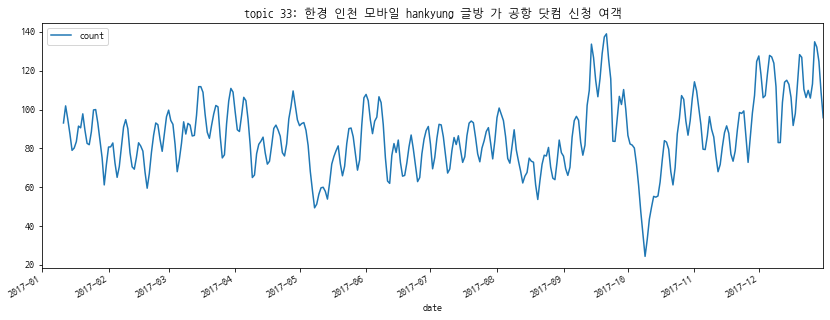

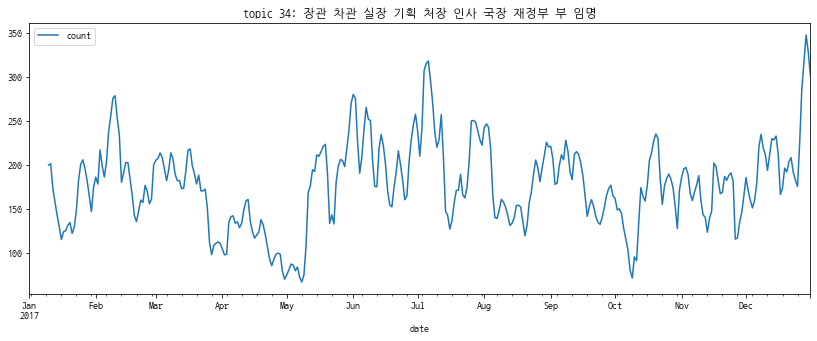

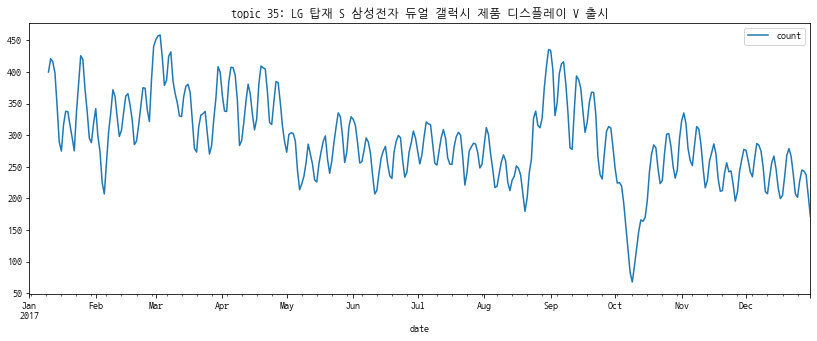

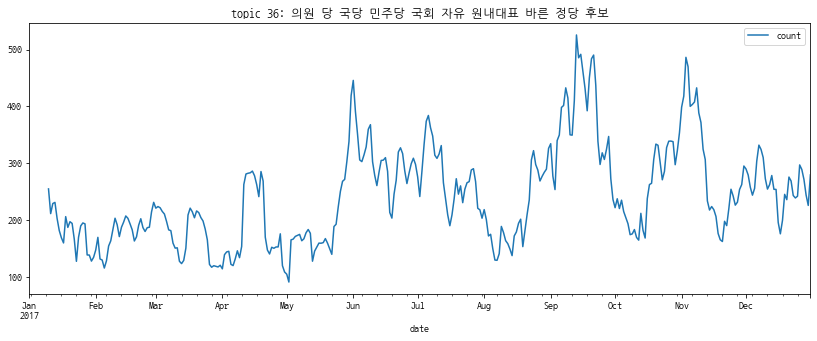

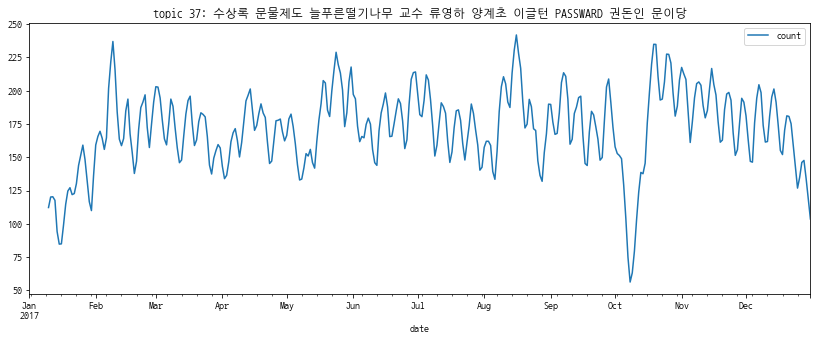

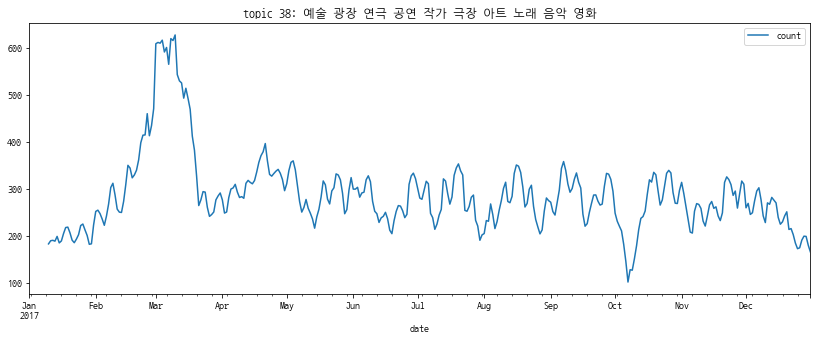

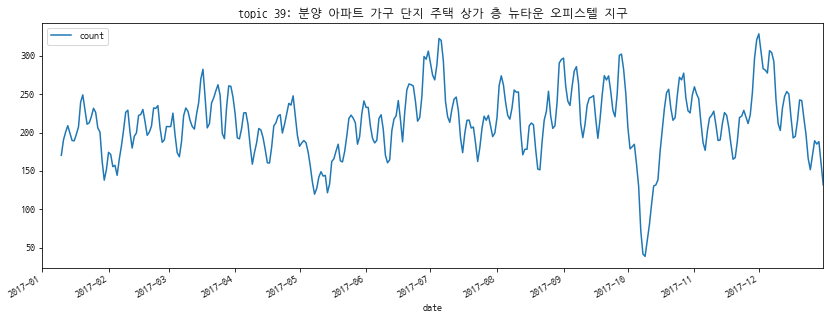

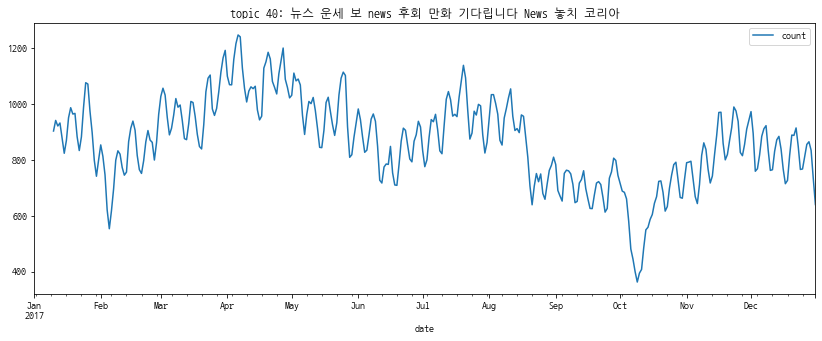

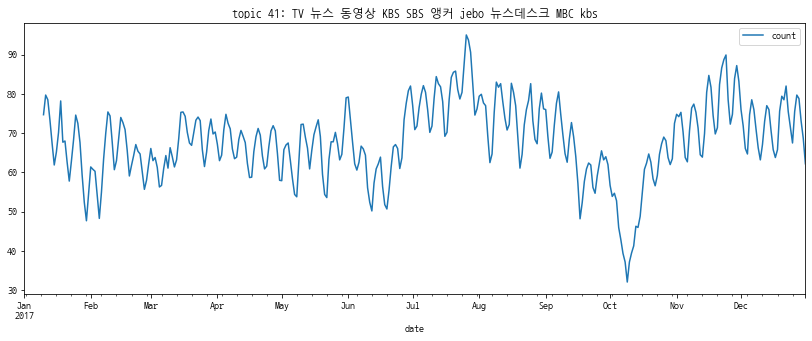

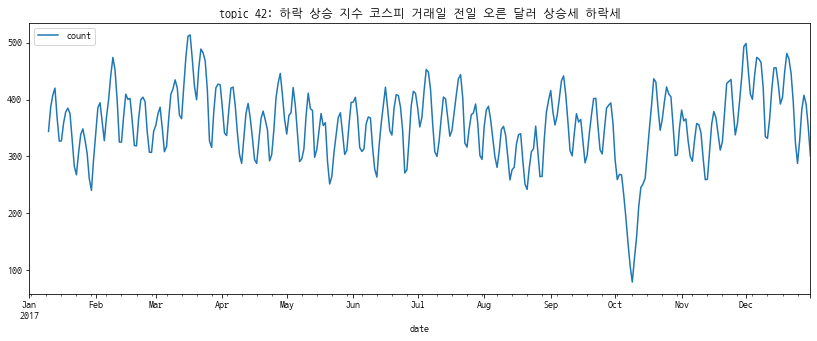

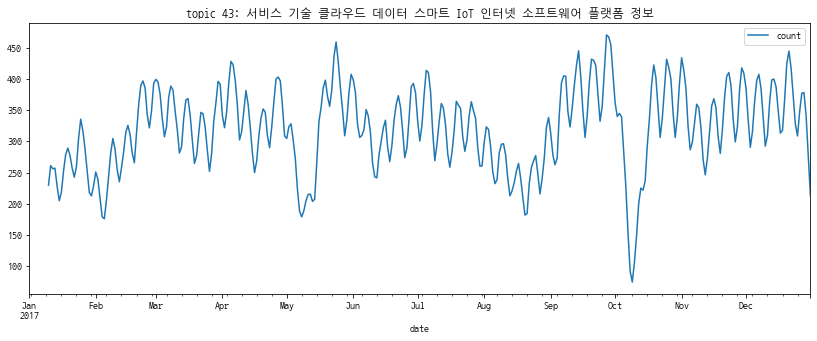

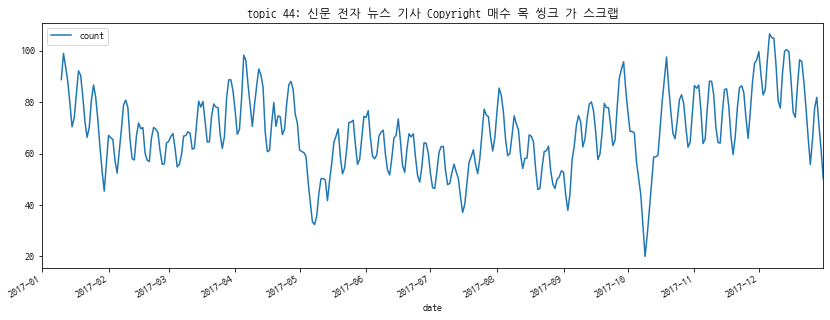

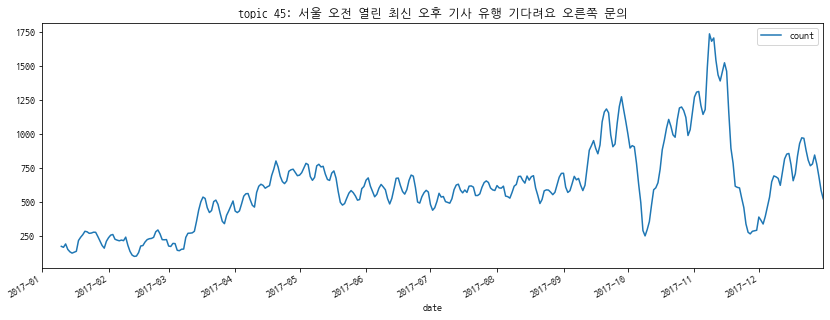

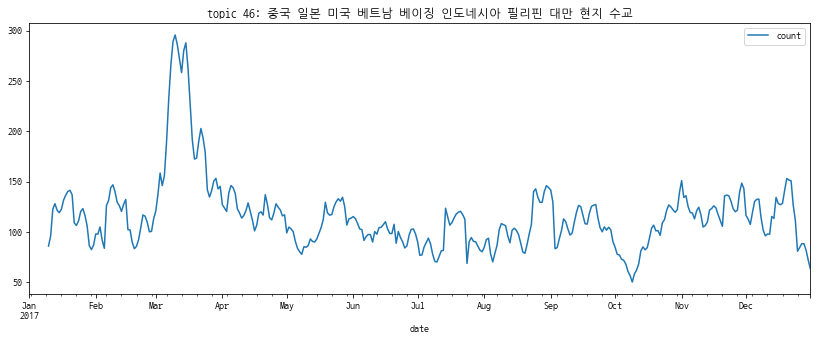

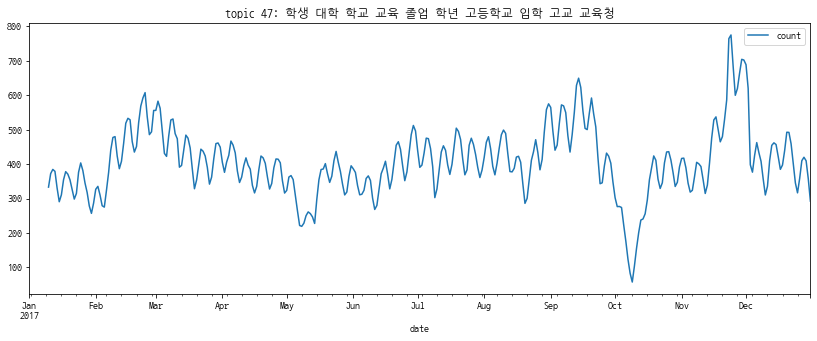

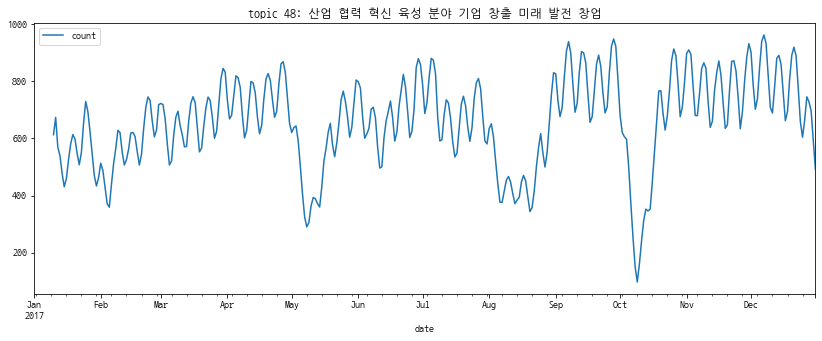

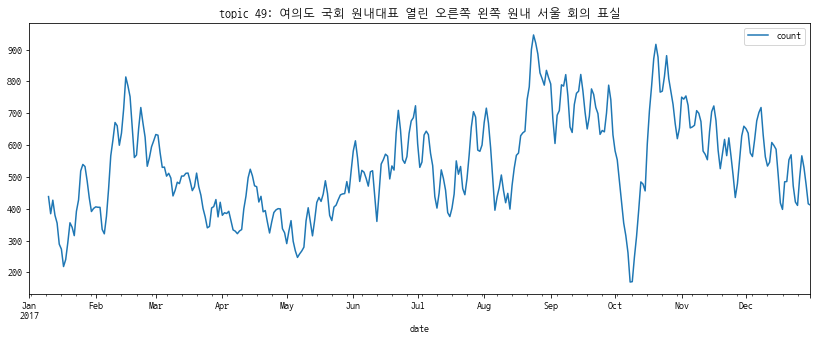

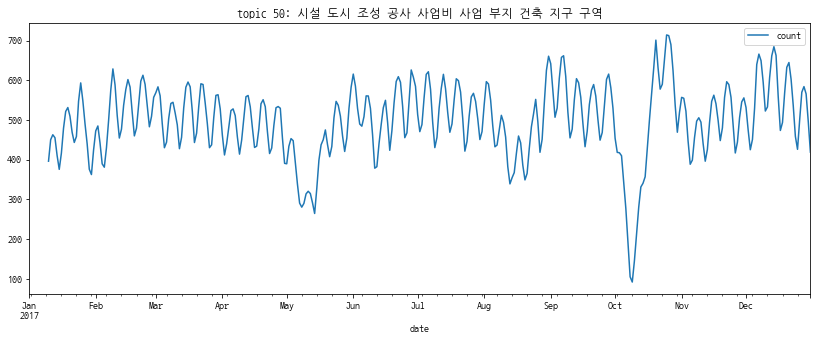

In [51]:
for topic_idx in range(0, 50):
    topic_words = ' '.join([decoder[i] for i in reversed(most_similar[topic_idx])])
    title_str = f'topic {topic_idx + 1}: {topic_words}'
    df_groupby.query(f'ptopic == {topic_idx}').droplevel(0).rolling(10).mean().plot(figsize=(14,5), title=title_str)
    

## Word Vectors

In [52]:
word_vectors_norm = word_vectors / np.linalg.norm(word_vectors, axis=-1)[:, None]
rev_decoder = {v: k for k,v in decoder.items()}
vocab = [i for i,j in sorted(rev_decoder.items(), key=lambda x:x[1])]

def get_vector(token):
    index = vocab.index(token)
    return word_vectors_norm[index, :].copy()

def most_similar(token, n=20):
    word_vector = get_vector(token)
    similarities = np.dot(word_vectors, word_vector)
    top = np.argsort(similarities)[::-1][:n]
    return [vocab[i] for i in top]

# This is Levy & Goldberg's 3Cosmul Metric
# Based on the Gensim implementation: https://github.com/piskvorky/gensim/blob/master/gensim/models/word2vec.py
def cosmul(positives, negatives, topn=20):
    positive = [get_vector(p) for p in positives]
    negative = [get_vector(n) for n in negatives]
    pos_dists = [((1 + np.dot(word_vectors_norm, term)) / 2.) for term in positive]
    neg_dists = [((1 + np.dot(word_vectors_norm, term)) / 2.) for term in negative]
    dists = np.prod(pos_dists, axis=0) / (np.prod(neg_dists, axis=0) + 1e-6)
    idxs = np.argsort(dists)[::-1][:topn]
    return [vocab[i] for i in idxs if (vocab[i] not in positives) and (vocab[i] not in negatives)]

def most_similar_posneg(positives, negatives, topn=20):
    positive = np.sum([get_vector(p) for p in positives], axis=0)
    negative = np.sum([get_vector(n) for n in negatives], axis=0)
    vector = positive - negative
    dists = np.dot(word_vectors_norm, vector)
    idxs = np.argsort(dists)[::-1][:topn]
    return [vocab[i] for i in idxs if (vocab[i] not in positives) and (vocab[i] not in negatives)]
            

In [87]:
' '.join(cosmul(['비트코인'], [], topn=20))

'화폐 코인 가상 빗 코빗 썸 채굴 암호 거래소 ICO 광풍 알트 거래자 리플 곡스 토큰 Bitcoin BCH CBOE'

In [80]:
' '.join(cosmul(['사이버', '공격'], [], topn=20))

'해킹 도스 해커 APT 랜섬 소행 보안 DDoS 취약점 라자루스 공격자 WannaCry 위협 노린 방첩 크라이 전산망 시만텍'

In [84]:
' '.join(cosmul(['자율', '주행', '미국'], [], topn=20))

'가속 모빌아이 테슬라 아이오 카 전기차 도요타 포드 닉 다이내믹스 우버 오토파일럿 EV 상용 파일럿 NHTSA 하이브리드 볼트'

In [93]:
' '.join(cosmul(['인공지능', '비서'], [], topn=20))

'알렉사 빅스비 스턴트 어시 Bixby 음성 컴퓨팅 인터페이스 클라우드 자연어 코타 에이브릴 Siri 디바이스 SDK 이인종 지능 NUGU'

In [65]:
' '.join(cosmul(['미국', '서울대'], ['대한민국'], topn=20))

'인디애나 조지타운 위스콘신 주립 홉킨스 하버드대 버클리 일리노이 코넬 스탠퍼드 코네티컷 퍼듀 매사추세츠 펜실베이니아 노스캐롤라이나 스탠포드 프린스턴 UC 하버드 미주리'

In [94]:
' '.join(cosmul(['일본', '서울대'], ['대한민국'], topn=20))

'도쿄대 도호쿠 와세다 게이오 문부 히로시 교도 교토 이해영 내각부 김병규 다카시 우에노 동경 현 일본학 岡 다나카 차오'

In [95]:
' '.join(cosmul(['이재용'], [], topn=20))

'부회장 삼성그룹 재청구 공판 박상진 뇌물죄 황성수 뇌물 최지성 재판 공여 특검 장충기 독대 총수 구형 영장 대법정 법정'

In [103]:
' '.join(cosmul(['뉴욕', '유럽'], ['미국'], topn=20))

'프랑크푸르트 런던 밀라노 CAC DAX 범유럽 FTSE 프랑스 스톡스 파리 암스테르담 리옹 유로 스위스 토론토 피렌체 시카고 지수인'

In [104]:
' '.join(cosmul(['플로리다', '유럽'], ['미국'], topn=20))

'포르투갈 남동부 시칠리아 퀘벡 카리브해 남서부 북서부 상파 소도시 캄 지중해 마리아 아일랜드 마드리드 크로아티아 피렌체 북동부 칸쿤 마이애미'

In [113]:
' '.join(cosmul(['마닐라', '미국'], ['필리핀'], topn=20))

'워싱턴 트럼프 도널드 뉴욕 DC 미 한미정상회담 WSJ 강영 백악관 월스트리트 오바마 로이터 렉스 슨 행정부 NYT 현지 틸러'

In [114]:
' '.join(cosmul(['마닐라', '중국'], ['필리핀'], topn=20))

'베이징 한중 북경 중관 방중 시진핑 관영 보복조치 사평 항저우 환구 정주호 중 김진방 리커창 샤먼 심재훈 주석은 충칭'